#  Learn Modulation and Demodulation in Nonlinear Channels with Deep Neural Networks by Autoencoders and End-to-end Training

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* End-to-end-learning of modulation scheme and demodulator in a simple nonlinear channel model with time-varying batch size

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [1] is given by an iterative application of the equation
$$
x_{k+1} = x_k\exp\left(\jmath\frac{L}{K}\gamma|x_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $x_0$ is the channel input (the modulated, complex symbols) and $x_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel Usually $K=50$ gives a good approximation.

[1] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," Proc. ECOC, Rome, Sep. 2018

In [2]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 50 # number of steps used in the channel model

# noise variance per step    
sigma_n = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    


# def simulate_channel(x, Pin, constellation):  
#     # modulate bpsk
#     input_power_linear = 10**((Pin-30)/10)
#     norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2)/input_power_linear)
#     modulated = constellation[x] * norm_factor
#     
# 
#     temp = np.array(modulated, copy=True)
#     for i in range(Kstep):
#         power = np.absolute(temp)**2
#         rotcoff = (L / Kstep) * gamma * power
#         
#         temp = temp * np.exp(1j*rotcoff) + sigma_n*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
#     return temp

Helper function to compute Bit Error Rate (BER)

In [3]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [4]:
# set input power
Pin = 4
input_power_linear = 10**((Pin-30)/10)

# number of points in constellation
M = 16


# validation set. Training examples are generated on the fly
N_valid = 100000

# number of neurons in hidden layers at transmitter
hidden_neurons_TX_1 = 50
hidden_neurons_TX_2 = 50
hidden_neurons_TX_3 = 50
hidden_neurons_TX_4 = 50
hidden_neurons_TX = [hidden_neurons_TX_1, hidden_neurons_TX_2, hidden_neurons_TX_3, hidden_neurons_TX_4]

# number of neurons in hidden layers at receiver
hidden_neurons_RX_1 = 50
hidden_neurons_RX_2 = 50
hidden_neurons_RX_3 = 50
hidden_neurons_RX_4 = 50
hidden_neurons_RX = [hidden_neurons_RX_1, hidden_neurons_RX_2, hidden_neurons_RX_3, hidden_neurons_RX_4]

# Generate Validation Data
y_valid = np.random.randint(M,size=N_valid)
y_valid_onehot = np.eye(M)[y_valid]

# meshgrid for plotting
# assume that the worst case constellation is the one where all points lie on a straight line starting at the center and then are spreaded equidistantly. In this case, this is the scaling factor of the constellation points and we assume that there is an (M+1)th point which defines ext_max 
ext_max = np.sqrt(M*input_power_linear)
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,400), np.linspace(-ext_max,ext_max,400))
meshgrid = np.column_stack((np.reshape(mgx,-1,1),np.reshape(mgy,-1,1))) 

This is the main function of TensorFlow that generates the computation graph. We have a single interface to the outside (a `tf.placeholder` which is the batch size. Here the idea is to vary the batch size during training. In the first iterations, we start with a small batch size to rapidly get to a working solution. The closer we come towards the end of the training we increase the batch size. If keeping the abtch size small, it may happen that there are no misclassifications in a small batch and there is no incentive of the training to improve. A larger batch size will most likely contain errors in the batch and hence there will be incentive to keep on training and improving. 

Here, the data is generated on the fly inside the graph, by using TensorFlows random number generation. As TensorFlow does not natively support complex numbers (at least in early versions), we decided to replace the complex number operations in the channel by a simple rotation matrix and treating real and imaginary parts separately.

We use the ELU activation function inside the neural network and employ the Adam optimization algorithm.

In [36]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_neurons_TX, hidden_neurons_RX):
        super(Autoencoder, self).__init__()
        # Define Transmitter Layer: Linear function, M input neurons (symbols), 2 output neurons (real and imaginary part)        
        self.fcT1 = nn.Linear(M,hidden_neurons_TX[0]) 
        self.fcT2 = nn.Linear(hidden_neurons_TX[0], hidden_neurons_TX[1]) 
        self.fcT3 = nn.Linear(hidden_neurons_TX[1], hidden_neurons_TX[2]) 
        self.fcT4 = nn.Linear(hidden_neurons_TX[2], hidden_neurons_TX[3]) 
        self.fcT5 = nn.Linear(hidden_neurons_TX[3], 2) 
        
        # Define Receiver Layer: Linear function, 2 input neurons (real and imaginary part), M output neurons (symbols)
        self.fcR1 = nn.Linear(2,hidden_neurons_RX[0]) 
        self.fcR2 = nn.Linear(hidden_neurons_RX[0], hidden_neurons_RX[1]) 
        self.fcR3 = nn.Linear(hidden_neurons_RX[1], hidden_neurons_RX[2]) 
        self.fcR4 = nn.Linear(hidden_neurons_RX[2], hidden_neurons_RX[3]) 
        self.fcR5 = nn.Linear(hidden_neurons_RX[3], M) 

        # Non-linearity (used in transmitter and receiver)
        self.activation_function = nn.ELU()      

    def forward(self, x, input_power_linear):
        # compute output
        encoded = self.network_transmitter(x)
        # compute normalization factor and normalize channel output
        norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded))/input_power_linear * 2 )                            
        modulated = encoded / norm_factor    
        received = self.channel_model(modulated)
        logits = self.network_receiver(received)
        return logits
        
    def network_transmitter(self,batch_labels):
        out = self.activation_function(self.fcT1(batch_labels))
        out = self.activation_function(self.fcT2(out))
        out = self.activation_function(self.fcT3(out))
        out = self.activation_function(self.fcT4(out))
        out = self.activation_function(self.fcT5(out))
        return out
    
    def network_receiver(self,inp):
        out = self.activation_function(self.fcR1(inp))
        out = self.activation_function(self.fcR2(out))
        out = self.activation_function(self.fcR3(out))
        out = self.activation_function(self.fcR4(out))
        logits = self.activation_function(self.fcR5(out))
        return logits
    
    def channel_model(self,modulated):
        # simulate the channel
        for i in range(Kstep):
            power = torch.norm(modulated, dim=1) ** 2
            rotcoff = (L / Kstep) * gamma * power
            
            # rotation matrix corresponding to exp(1j*rotcoff)        
            temp = torch.stack([modulated[:,0] * torch.cos(rotcoff) - modulated[:,1]*torch.sin(rotcoff), modulated[:,0]*torch.sin(rotcoff)+modulated[:,1]*torch.cos(rotcoff)], dim=1)        
            modulated = torch.add(temp, sigma_n*torch.randn(len(modulated),2).to(device))
        return modulated  

In [37]:
a = torch.empty([4,2])
print(a.random_(5))
print(torch.norm(a, dim=1))

tensor([[4., 2.],
        [4., 3.],
        [1., 3.],
        [3., 1.]])
tensor([4.4721, 5.0000, 3.1623, 3.1623])


Now, carry out the training as such. First initialize the variables and then loop through the training. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data.

In [41]:
model = Autoencoder(hidden_neurons_TX, hidden_neurons_RX)
model.to(device)

softmax = nn.Softmax(dim=1)

# Cross Entropy loss
loss_fn = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  


# Training parameters
num_epochs = 20
batches_per_epoch = 300

# Vary batch size during training
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs)

validation_SERs = np.zeros(num_epochs)
validation_received = []
decision_region_evolution = []
constellations = []

print('Start Training')
for epoch in range(num_epochs):
    
    batch_labels = torch.empty(int(batch_size_per_epoch[epoch]), device=device)

    for step in range(batches_per_epoch):
        # Generate training data: In most cases, you have a dataset and do not generate a training dataset during training loop
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(M)
        batch_labels_onehot = torch.zeros(int(batch_size_per_epoch[epoch]), M, device=device)
        batch_labels_onehot[range(batch_labels_onehot.shape[0]), batch_labels.long()]=1

        # Propagate (training) data through the net
        logits = model(batch_labels_onehot, input_power_linear)

        # compute loss
        loss = loss_fn(logits.squeeze(), batch_labels.long())

        # compute gradients
        loss.backward()
        
        # Adapt weights
        optimizer.step()
        
        # reset gradients
        optimizer.zero_grad()
        
    # compute validation SER
    out_valid = softmax(model(torch.Tensor(y_valid_onehot).to(device), input_power_linear))
    validation_SERs[epoch] = SER(out_valid.detach().cpu().numpy().squeeze(), y_valid)
    print('Validation SER after epoch %d: %f (loss %1.8f)' % (epoch, validation_SERs[epoch], loss.detach().cpu().numpy()))                
    
    # calculate and store received validation data
    encoded = model.network_transmitter(torch.Tensor(y_valid_onehot).to(device))
    norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded))/input_power_linear * 2 )                          
    modulated = encoded / norm_factor    
    received = model.channel_model(modulated)
    validation_received.append(received.detach().cpu().numpy())
    
    # calculate and store constellation
    encoded = model.network_transmitter(torch.eye(M).to(device))
    norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded))/input_power_linear * 2 )                         
    modulated = encoded / norm_factor 
    constellations.append(modulated.detach().cpu().numpy())
        
    # store decision region for generating the animation
    mesh_prediction = softmax(model.network_receiver(torch.Tensor(meshgrid).to(device)))
    decision_region_evolution.append(0.195*mesh_prediction.detach().cpu().numpy() + 0.4)
    
print('Training finished')

Start Training
Validation SER after epoch 0: 0.878500 (loss 2.34135127)
Validation SER after epoch 1: 0.819970 (loss 2.16035342)
Validation SER after epoch 2: 0.784050 (loss 2.00592875)
Validation SER after epoch 3: 0.781990 (loss 2.00078797)
Validation SER after epoch 4: 0.734200 (loss 1.97260237)
Validation SER after epoch 5: 0.654550 (loss 1.65692925)
Validation SER after epoch 6: 0.531820 (loss 1.26281226)
Validation SER after epoch 7: 0.462610 (loss 1.02830267)
Validation SER after epoch 8: 0.347970 (loss 0.85715109)
Validation SER after epoch 9: 0.186650 (loss 0.52846009)
Validation SER after epoch 10: 0.121720 (loss 0.35626280)
Validation SER after epoch 11: 0.094670 (loss 0.30681601)
Validation SER after epoch 12: 0.072110 (loss 0.22872867)
Validation SER after epoch 13: 0.055410 (loss 0.17593777)
Validation SER after epoch 14: 0.041100 (loss 0.12667750)
Validation SER after epoch 15: 0.042460 (loss 0.11300642)
Validation SER after epoch 16: 0.028190 (loss 0.10022979)
Validatio

Plt decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing BERs and plotting, there is no feedback towards the training!

In [42]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

# find minimum SER from validation set
min_SER_iter = np.argmin(validation_SERs)
print('Minimum SER obtained: %1.5f' % validation_SERs[min_SER_iter])

ext_max_plot = 1.05*max(max(abs(validation_received[min_SER_iter][:,0])), max(abs(validation_received[min_SER_iter][:,1])))

Minimum SER obtained: 0.01723


Text(0.5, 1.0, 'Decision regions')

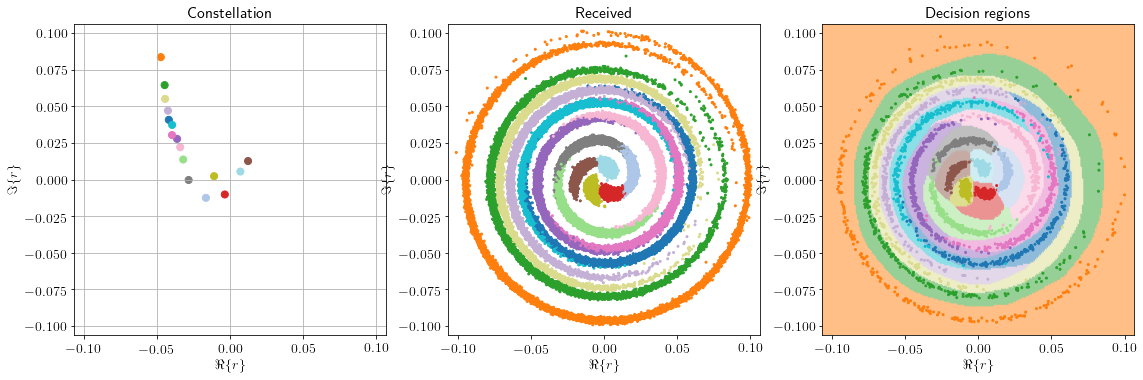

In [46]:
%matplotlib inline
plt.figure(figsize=(19,6))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=True)
    
plt.subplot(131)
plt.scatter(constellations[min_SER_iter][:,0], constellations[min_SER_iter][:,1], c=range(M), cmap='tab20',s=50)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=14)
plt.ylabel(r'$\Im\{r\}$',fontsize=14)
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.grid(which='both')
plt.title('Constellation',fontsize=16)

plt.subplot(132)
#plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(validation_received[min_SER_iter][:,0], validation_received[min_SER_iter][:,1], c=y_valid, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=14)
plt.ylabel(r'$\Im\{r\}$',fontsize=14)
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.title('Received',fontsize=16)

plt.subplot(133)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(validation_received[min_SER_iter][0:4000,0], validation_received[min_SER_iter][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
plt.axis('scaled')
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.xlabel(r'$\Re\{r\}$',fontsize=14)
plt.ylabel(r'$\Im\{r\}$',fontsize=14)
plt.title('Decision regions',fontsize=16)

#plt.savefig('decision_region_AE_Pin%d.pdf' % Pin,bbox_inches='tight')

Generate animation and save as a gif.

<IPython.core.display.Javascript object>


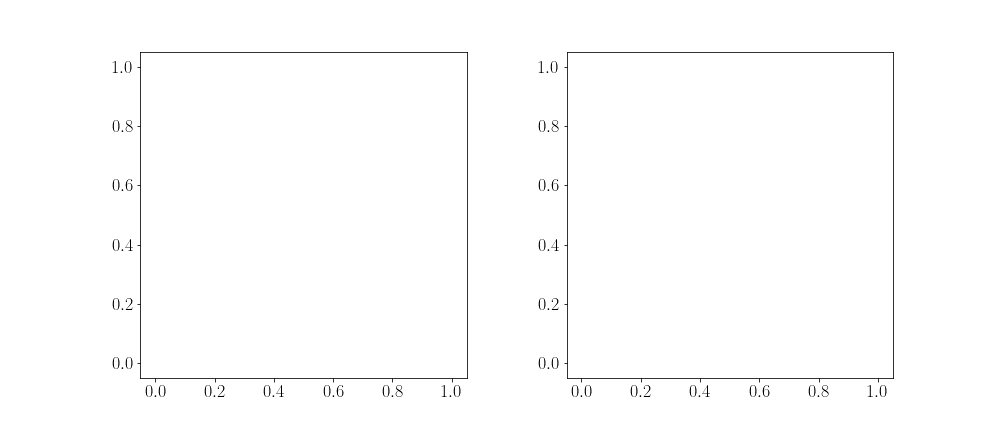

In [49]:
%matplotlib notebook
%matplotlib notebook
# Generate animation
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.axis('scaled')
ax2.axis('scaled')

written = False
def animate(i):
    ax1.clear()
    ax1.scatter(constellations[i][:,0], constellations[i][:,1], c=range(M), cmap='tab20',s=50)

    ax2.clear()
    #ax2.scatter([0,0.02],[0.02,0], c=[1,2], cmap='tab20',s=100)
    #decision_scatter = np.argmax(decision_region_evolution[i], 1)
    decision_scatter = np.argmax(decision_region_evolution[i], 1)
    ax2.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
    ax2.scatter(validation_received[i][0:4000,0], validation_received[i][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
    
    #plt.scatter(meshgrid[:,0] * ext_max,meshgrid[:,1] * ext_max, c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4, marker='s')
    #plt.scatter(X_valid[0:4000,0]*ext_max, X_valid[0:4000,1]*ext_max, c=y_valid[0:4000], cmap='tab20',s=4)
    ax1.set_xlim(( -ext_max_plot, ext_max_plot))
    ax1.set_ylim(( -ext_max_plot, ext_max_plot))
    ax2.set_xlim(( -ext_max_plot, ext_max_plot))
    ax2.set_ylim(( -ext_max_plot, ext_max_plot))
    ax1.set_title('Constellation', fontsize=14)
    ax2.set_title('Decision regions', fontsize=14)
    
    ax1.set_xlabel(r'$\Re\{r\}$',fontsize=14)
    ax1.set_ylabel(r'$\Im\{r\}$',fontsize=14)
    ax2.set_xlabel(r'$\Re\{r\}$',fontsize=14)
    ax2.set_ylabel(r'$\Im\{r\}$',fontsize=14)

    
anim = animation.FuncAnimation(fig, animate, frames=min_SER_iter+1, interval=200, blit=False)
fig.show()
#anim.save('learning_decision_AE_Pin%d_varbatch.gif' % Pin, writer=PillowWriter(fps=5))